In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [43]:
class Dataset(BaseDataset):
    """Image Dataset

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = []
        for images in os.listdir(images_dir):
            self.ids.append(images.split('.')[0])
  

        self.images_fps = [os.path.join(images_dir, image_id + '.jpg',) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id + '.png') for image_id in self.ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [47]:
def get_training_augmentation(resize_to=(320,640), crop_size=(288,576)):
    resize_to=(320,640)
    crop_size=(288,576)
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.Resize(*resize_to),
        albu.RandomCrop(*crop_size),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [11]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [49]:
DATA_DIR = 'prepared_dataset'
x_train_dir = os.path.join(DATA_DIR, 'image')
y_train_dir = os.path.join(DATA_DIR, 'mask')

DATA_DIR = 'val_dataset'
x_valid_dir = os.path.join(DATA_DIR, 'image')
y_valid_dir = os.path.join(DATA_DIR, 'mask')

train_dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())
val_dataset = Dataset(x_valid_dir, y_valid_dir)

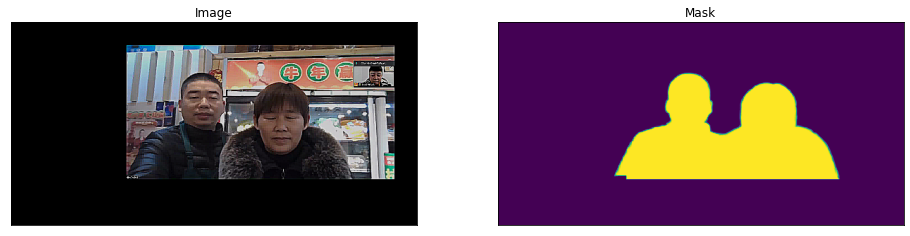

(288, 576, 3)


In [50]:
image, mask = train_dataset[2] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)
print(image.shape)